<a href="https://colab.research.google.com/github/snaiws/NLP_project/blob/RoBERTa%2Fbaseline/STS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Textual Similarity for Korean

### BASELINE : RoBERTa

#### 진행 사항
1. 전처리 진행
  - 중복행 삭제
  - 문장검사

2. 모델 정리 및 오류 수정
  - 현재 오류 : 메모리....오류...

3. 하이퍼 파라미터 튜닝 및 성능 향상
  - 파라미터 사용 정보

```python
    # argument setting
    task = "sts"
    model_checkpoint = "roberta-base" 
    train_batch_size = 32
    eval_batch_size = 64
    epochs=4
    patience=1
    loss_fct = nn.CrossEntropyLoss()
    optimizer = AdamW
    # 실험용 epoch=1
```



# Import

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 54.7 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 6.6 MB 52.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import sys
import re
import pandas as pd
import numpy as np 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,  RandomSampler, SequentialSampler, random_split
from torch.nn.utils import clip_grad_norm_

from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

In [36]:
#reset gpu cache
import gc
gc.collect()
torch.cuda.empty_cache()

In [4]:
# seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# device type
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

# available GPUs : 1
GPU name : Tesla T4
cuda


# Data upload

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
cd /content/drive/MyDrive/AIBootCamp/NLP

/content/drive/MyDrive/AIBootCamp/NLP


In [8]:
_CUR_DIR = os.path.abspath(os.curdir)
print(f"My current directory : {_CUR_DIR}")
_DATA_DIR = os.path.join(_CUR_DIR, "data/klue-sts-v1.1")
print(f"My data directory : {_DATA_DIR}")

My current directory : /content/drive/MyDrive/AIBootCamp/NLP
My data directory : /content/drive/MyDrive/AIBootCamp/NLP/data/klue-sts-v1.1


In [9]:
# 파일 내 json 불러오기
train_all = pd.read_json('./data/klue-sts-v1.1/klue-sts-v1.1_train.json')
test = pd.read_json('./data/klue-sts-v1.1/klue-sts-v1.1_dev.json')

In [10]:
# shape
train_all.shape, test.shape

((11668, 6), (519, 6))

# Data Preprocessing

### 미리 검사

In [98]:
# 중복 확인
train_all[train_all.duplicated(['sentence1', 'sentence2'],keep=False)]

,guid,source,sentence1,sentence2,labels,annotations
1514,klue-sts-v1_train_01514,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['0..."
1661,klue-sts-v1_train_01661,airbnb-rtt,택시타고 공항갔을 때 20유로로 15분내에 도착했었어요.,"택시를 타고 공항에 갔을 때, 15분만에 20유로에 도착했습니다.","{'label': 4.7, 'real-label': 4.666666666666667...","{'agreement': '0:0:0:0:2:4', 'annotators': ['1..."
1715,klue-sts-v1_train_01715,airbnb-rtt,택시타고 공항갔을 때 20유로로 15분내에 도착했었어요.,"택시를 타고 공항에 갔을 때, 15분만에 20유로에 도착했습니다.","{'label': 4.7, 'real-label': 4.666666666666667...","{'agreement': '0:0:0:0:2:4', 'annotators': ['1..."
3872,klue-sts-v1_train_03872,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.9, 'real-label': 4.857142857142857...","{'agreement': '0:0:0:0:1:6', 'annotators': ['1..."
5139,klue-sts-v1_train_05139,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.6, 'real-label': 4.571428571428571...","{'agreement': '0:0:0:0:3:4', 'annotators': ['0..."
5292,klue-sts-v1_train_05292,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['0..."
7045,klue-sts-v1_train_07045,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.0, 'real-label': 4.0, 'binary-labe...","{'agreement': '0:0:0:1:5:1', 'annotators': ['1..."
10908,klue-sts-v1_train_10908,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.0, 'real-label': 4.0, 'binary-labe...","{'agreement': '0:0:0:1:5:1', 'annotators': ['1..."
10939,klue-sts-v1_train_10939,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.6, 'real-label': 4.571428571428571...","{'agreement': '0:0:0:0:3:4', 'annotators': ['0..."
11112,klue-sts-v1_train_11112,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.9, 'real-label': 4.857142857142857...","{'agreement': '0:0:0:0:1:6', 'annotators': ['1..."


In [70]:
# 중복 삭제
train_all = train_all.drop_duplicates(['sentence1', 'sentence2'],keep=False).reset_index(drop=True)

In [71]:
# Null 값 확인
train_all.isnull().sum()

guid           0
source         0
sentence1      0
sentence2      0
labels         0
annotations    0
dtype: int64

### 모듈화

In [11]:
class Preprocess:
    def __init__(self,train,test):
        self.train=train
        self.test=test

    def check_st(self, text):
      text = re.sub('a-zA-Z一-龥㐀-䶵豈-龎[-=+,#/\?:^$.@*\"※~&%ㆍ·!』\\‘〈〉|\(\)\[\]\<\>`\'…》《]','', text)
      return text
    
    def make_input(self,dataset):
      '''
      transform to the Input example
      '''
      #중복 제거
      dataset = dataset.drop_duplicates(['sentence1','sentence2']).reset_index(drop=True)

      sent_pairs = [sent1+' '+sent2 for sent1, sent2 in zip(dataset['sentence1'], dataset['sentence2'])]
      sent_pairs = list(map(self.check_st, sent_pairs))

      #real-label -> regression 활용 가능?
      r_score=[i['real-label'] for i in dataset['labels']]

      #custom label : int
      c_score=[round(i['real-label']) for i in dataset['labels']]

      #b_score label : [0,1] -> f1 scroe
      b_score = [i['binary-label'] for i in dataset['labels']]
      input_examples = pd.DataFrame({'guid': dataset['guid'], 'sent_pair' : sent_pairs, 'r_label' : r_score, 'c_label' : c_score, 'b_label' : b_score})

      return input_examples

In [12]:
pp=Preprocess(train_all,test)

In [13]:
train = pp.make_input(train_all)
test = pp.make_input(test)

## Data Visualization

#### 이 라벨을 사용하려면 Data Agument가 필요할듯!!

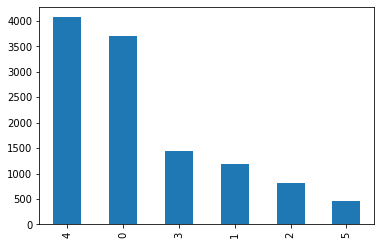

In [116]:
train['c_label'].value_counts().plot.bar()

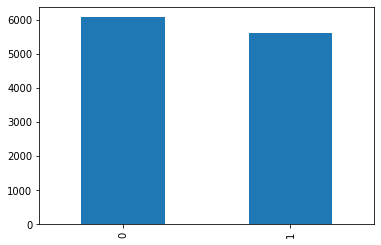

In [117]:
train['b_label'].value_counts().plot.bar()

# Data Set

In [14]:
# Custom Dataset
class CustomDataset(Dataset):
    """
    - input_data: list of string
    - target_data: list of int
    """
    
    def __init__(self, input_data:list, target_data:list) -> None:
        self.X = input_data
        self.Y = target_data
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [15]:
train_dataset = CustomDataset(train.sent_pair.to_list(), train.c_label.to_list())
test_dataset = CustomDataset(test.sent_pair.to_list(), test.c_label.to_list())

## Split Data

In [16]:
n_sample = train.shape[0] # train 전체 길이
n_train = int(n_sample*0.9)
n_valid = n_sample-n_train
train_dataset, valid_dataset = random_split(train_dataset, [n_train, n_valid])

In [17]:
print(f"Train Dataset len: {len(train_dataset)}")
print(f"Valid Dataset len: {len(valid_dataset)}")
print(f"Test Dataset len: {len(test_dataset)}")

Train Dataset len: 10494
Valid Dataset len: 1167
Test Dataset len: 519


# ARGUMENT

In [18]:
# argument setting
task = "sts"
model_checkpoint = "roberta-base" 
train_batch_size = 32
eval_batch_size = 64
epochs=4
patience=1
loss_fct = nn.CrossEntropyLoss()

# Data Loader

In [19]:
# Custom collate_fn 
def custom_collate_fn(batch):
    """
    한 배치 내 문장들을 tokenizing 한 후 텐서로 변환함. 
    이때, dynamic padding (즉, 같은 배치 내 토큰의 개수가 동일할 수 있도록, 부족한 문장에 [PAD] 토큰을 추가하는 작업)을 적용
    
    한 배치 내 레이블(target)은 텐서화 함.
    
    - batch: list of tuples (input_data(string), target_data(int))
    """
    input_list, target_list = [], []

    tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint)
    
    for _input, _target in batch:
        input_list.append(_input)
        target_list.append(_target)
    
    tensorized_input = tokenizer(
        input_list,
        add_special_tokens=True,
        padding="longest", # 배치내 가장 긴 문장을 기준으로 부족한 문장은 [PAD] 토큰을 추가
        truncation=True, # max_length를 넘는 문장은 이 후 토큰을 제거함
        max_length=512,
        return_tensors='pt' # 토크나이즈된 결과 값을 텐서 형태로 반환
    )
    
    tensorized_label = torch.tensor(target_list)
    
    return tensorized_input, tensorized_label

In [20]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    sampler = RandomSampler(train_dataset),
    collate_fn = custom_collate_fn
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size = eval_batch_size,
    sampler = SequentialSampler(valid_dataset),
    collate_fn = custom_collate_fn
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size = eval_batch_size,
    sampler = SequentialSampler(test_dataset),
    collate_fn = custom_collate_fn
)
print(f"Train dataloader # steps: {len(train_dataloader)}")
print(f"Valid dataloader # steps: {len(valid_dataloader)}")
print(f"Test dataloader # steps: {len(test_dataloader)}")

Train dataloader # steps: 328
Valid dataloader # steps: 19
Test dataloader # steps: 9


# Model

In [21]:
class RoBerta_baseline(nn.Module):

    def __init__(self, hidden_size: int, n_label: int):
        super(RoBerta_baseline, self).__init__()

        self.roberta = RobertaModel.from_pretrained(model_checkpoint)

        dropout_rate = 0.1
        linear_layer_hidden_size = 32

        self.classifier = nn.Sequential(nn.Linear(hidden_size, linear_layer_hidden_size),
                                        nn.ReLU(),
                                        nn.Dropout(dropout_rate),
                                        nn.Linear(linear_layer_hidden_size, n_label)
                                        )

    

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        
        # RoBERTa 모델의 마지막 레이어의 첫번재 토큰을 인덱싱
        last_hidden_states = outputs[0] # last hidden states (batch_size, sequence_len, hidden_size)
        cls_token_last_hidden_states = last_hidden_states[:,0,:] # (batch_size, first_token, hidden_size)

        logits = self.classifier(cls_token_last_hidden_states)

        return logits

In [22]:
def initializer(train_dataloader, epochs=2):
    """
    모델, 옵티마이저, 스케쥴러 초기화
    """
    
    model = RoBerta_baseline(hidden_size=768, n_label=6)
    print(model)

    optimizer = AdamW(
        model.parameters(), # update 대상 파라미터를 입력
        lr=2e-5,
        eps=1e-8
    )
    
    total_steps = len(train_dataloader) * epochs
    print(f"Total train steps with {epochs} epochs: {total_steps}")

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0, # 여기서는 warmup을 사용하지 않는다.
        num_training_steps = total_steps
    )

    return model, optimizer, scheduler

In [23]:
model, optimizer, scheduler = initializer(train_dataloader, epochs)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RoBerta_baseline(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [32]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=1, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = os.path.abspath(os.curdir)

    def __call__(self, val_loss, model, optimizer, scheduler, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
            self.counter = 0

    def save_checkpoint(self, model, optimizer, scheduler, epoch, loss):
      file_name = f'{self.path}/model_ckpt_{self.epoch}'
      
      torch.save(
          {
              'epoch': self.epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'scheduler_state_dict': scheduler.state_dict(),
              'loss' : loss
          }, 
          file_name
      )
      
      print(f"Saving epoch {epoch} checkpoint at {file_name}")

In [33]:
def validate(model, valid_dataloader):
    valid_losses = []

    # 모델을 evaluate 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    total_loss, total_acc= 0,0
        
    for step, batch in enumerate(valid_dataloader):
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
            
        batch_input, batch_label = batch
            
        # gradient 계산하지 않음
        with torch.no_grad():
            logits = model(**batch_input)
            
        # loss
        loss = loss_fct(logits, batch_label)
        total_loss += loss.item()
        valid_losses.append(loss.item())

        # accuracy
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1).flatten()
        acc = (preds == batch_label).cpu().numpy().mean()
        total_acc+=acc
    
    total_loss = total_loss/(step+1)
    total_acc = total_acc/(step+1)*100

    return total_loss, total_acc, valid_losses

In [34]:
def train_model(model, train_dataloader, valid_dataloader=None, epochs=1):
        # early_stopping object의 초기화
        early_stopping = EarlyStopping(patience = patience, verbose = True)
        
        # train_dataloaer 학습을 epochs만큼 반복
        for epoch in range(1, epochs + 1):
            print(f"*****Epoch {epoch} Train Start*****")
            
            # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
            total_loss, batch_loss, batch_count = 0,0,0
        
            # model을 train 모드로 설정 & device 할당
            model.train()
            model.to(device)
            
            # data iterator를 돌면서 하나씩 학습
            for step, batch in enumerate(train_dataloader):
                batch_count+=1
                
                # tensor 연산 전, 각 tensor에 device 할당
                batch = tuple(item.to(device) for item in batch)
            
                batch_input, batch_label = batch
            
                # batch마다 모델이 갖고 있는 기존 gradient를 초기화
                model.zero_grad()
            
                # forward
                logits = model(**batch_input)
            
                # loss
                loss = loss_fct(logits, batch_label)
                batch_loss += loss.item()
                total_loss += loss.item()
            
                # backward -> 파라미터의 미분(gradient)를 자동으로 계산
                loss.backward()
                
                # gradient clipping 적용 
                clip_grad_norm_(model.parameters(), 1.0)
                
                # optimizer & scheduler 업데이트
                optimizer.step()
                scheduler.step()

                # 배치 10개씩 처리할 때마다 평균 loss와 lr를 출력
                if (step % 10 == 0 and step != 0):
                    learning_rate = optimizer.param_groups[0]['lr']
                    print(f"Epoch: {epoch}, Step : {step}, LR : {learning_rate}, Avg Loss : {batch_loss / batch_count:.4f}")

                    # reset 
                    batch_loss, batch_count = 0,0
            
            print(f"Epoch {epoch} Total Mean Loss : {total_loss/(step+1):.4f}")
            print(f"*****Epoch {epoch} Train Finish*****\n")
            
            if valid_dataloader is not None:
                print(f"*****Epoch {epoch} Valid Start*****")
                valid_loss, valid_acc = validate(model, valid_dataloader)
                print(f"Epoch {epoch} Valid Loss : {valid_loss:.4f} Valid Acc : {valid_acc:.2f}")
                print(f"*****Epoch {epoch} Valid Finish*****\n")

            # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
            #  만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break
                
            # checkpoint 저장
            early_stopping.save_checkpoint(".", model, optimizer, scheduler, epoch, total_loss/(step+1))
                
        print("Train Completed. End Program.")

In [37]:
train_model(model, train_dataloader, 1)

*****Epoch 1 Train Start*****


RuntimeError: ignored